## 3. Vader sentiment analysis

In [32]:
import pandas as pd
import re
from utils import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk 
from plotnine import *
from bs4 import BeautifulSoup
from emot.emo_unicode import UNICODE_EMOJI 
from emot.emo_unicode import EMOTICONS_EMO 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm 
import string 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [2]:
# Read csv
df = pd.read_csv("data_w_gender_franyang_oct_18.csv")

In [3]:
df

,Name,Review,Rating,#ThumbsUp,Date&Time,App,Gender
0,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,Men
1,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,Men
2,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,Men
3,Lukas Rukštelis,Good app.,5,0,18-02-2022 00:57,Tinder,Men
4,Joe burns,Just tested after originally noticing a flux ;...,1,0,18-02-2022 00:37,Tinder,Men
...,...,...,...,...,...,...,...
391058,Shraddha Nigdikar,I don't see why this one is any different than...,2,0,13-07-2017 22:52,Hinge,Women
391059,Helen Rogers,AWFUL! *PROFILE FRAUD ALERT* NO Facebook Fri...,2,0,13-07-2017 04:12,Hinge,Women
391060,Lindsay Maguire,"I first gave this app 1 star!, but they addres...",3,11,12-07-2017 15:44,Hinge,Women
391061,Jennifer A.,Why on earth would you only allow people with ...,1,0,12-07-2017 02:33,Hinge,Women


### Distribution of rating

In [29]:
n_ratings = df.groupby('Rating')['Rating'].count().to_frame().unstack().reset_index().rename(columns = {0:'Count'})

In [30]:
n_ratings

,level_0,Rating,Count
0,Rating,1,144790
1,Rating,2,32638
2,Rating,3,34982
3,Rating,4,52975
4,Rating,5,125678


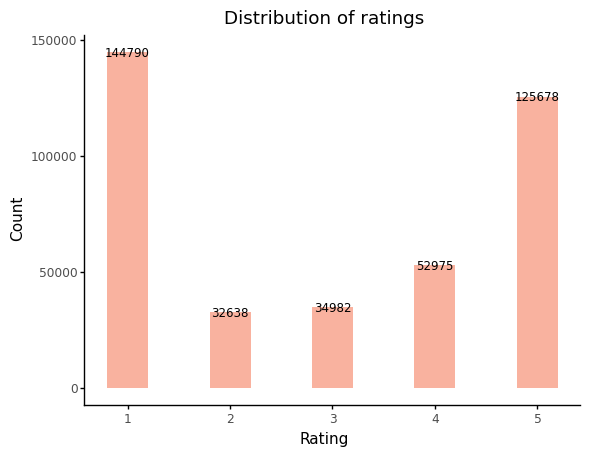

<ggplot: (8766748632311)>

In [39]:
(ggplot(n_ratings,
      aes(x = "Rating", y = "Count")) + 
 geom_bar(stat="identity", fill="#f68060", alpha=.6, width=.4) + 
 geom_text(aes(label="Count"), color="black", size=8.5)+
 labs(x = "Rating", title = "Distribution of ratings") + 
 theme_classic())

### Preprocessing

In [39]:
def clean_text_lemma(my_text):
   # lemmatizing 
    lemmatizer = WordNetLemmatizer()
    my_text = lemmatizer.lemmatize(my_text)
    
    # change emojis into words 
    for emot in UNICODE_EMOJI:
        my_text = my_text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))

    return my_text

In [40]:
df['review_lemma'] = df['Review'].apply(lambda x: clean_text_lemma(x))

In [41]:
df

,Name,Review,Rating,#ThumbsUp,Date&Time,App,Gender,review_lemma,review_tokenized
0,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,Men,Tinder would be so much better if we could spe...,[Tinder would be so much better if we could sp...
1,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,Men,Still doesn't correctly notify matches or mess...,[Still doesn't correctly notify matches or mes...
2,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,Men,Love it!,[Love it!]
3,Lukas Rukštelis,Good app.,5,0,18-02-2022 00:57,Tinder,Men,Good app.,[Good app.]
4,Joe burns,Just tested after originally noticing a flux ;...,1,0,18-02-2022 00:37,Tinder,Men,Just tested after originally noticing a flux ;...,[Just tested after originally noticing a flux ...
...,...,...,...,...,...,...,...,...,...
391058,Shraddha Nigdikar,I don't see why this one is any different than...,2,0,13-07-2017 22:52,Hinge,Women,I don't see why this one is any different than...,[I don't see why this one is any different tha...
391059,Helen Rogers,AWFUL! *PROFILE FRAUD ALERT* NO Facebook Fri...,2,0,13-07-2017 04:12,Hinge,Women,AWFUL! *PROFILE FRAUD ALERT* NO Facebook Fri...,"[AWFUL!, *PROFILE FRAUD ALERT* NO Facebook Fr..."
391060,Lindsay Maguire,"I first gave this app 1 star!, but they addres...",3,11,12-07-2017 15:44,Hinge,Women,"I first gave this app 1 star!, but they addres...","[I first gave this app 1 star!, but they addre..."
391061,Jennifer A.,Why on earth would you only allow people with ...,1,0,12-07-2017 02:33,Hinge,Women,Why on earth would you only allow people with ...,[Why on earth would you only allow people with...


### Sentiment analysis

In [42]:
sia = SentimentIntensityAnalyzer()

In [69]:
df['sent_score'] = df['review_lemma'].map(lambda x: sia.polarity_scores(x))

In [70]:
df

,Name,Review,Rating,#ThumbsUp,Date&Time,App,Gender,review_lemma,review_tokenized,sent_score
0,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,Men,Tinder would be so much better if we could spe...,[Tinder would be so much better if we could sp...,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp..."
1,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,Men,Still doesn't correctly notify matches or mess...,[Still doesn't correctly notify matches or mes...,"{'neg': 0.147, 'neu': 0.776, 'pos': 0.077, 'co..."
2,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,Men,Love it!,[Love it!],"{'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'comp..."
3,Lukas Rukštelis,Good app.,5,0,18-02-2022 00:57,Tinder,Men,Good app.,[Good app.],"{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp..."
4,Joe burns,Just tested after originally noticing a flux ;...,1,0,18-02-2022 00:37,Tinder,Men,Just tested after originally noticing a flux ;...,[Just tested after originally noticing a flux ...,"{'neg': 0.0, 'neu': 0.95, 'pos': 0.05, 'compou..."
...,...,...,...,...,...,...,...,...,...,...
391058,Shraddha Nigdikar,I don't see why this one is any different than...,2,0,13-07-2017 22:52,Hinge,Women,I don't see why this one is any different than...,[I don't see why this one is any different tha...,"{'neg': 0.0, 'neu': 0.903, 'pos': 0.097, 'comp..."
391059,Helen Rogers,AWFUL! *PROFILE FRAUD ALERT* NO Facebook Fri...,2,0,13-07-2017 04:12,Hinge,Women,AWFUL! *PROFILE FRAUD ALERT* NO Facebook Fri...,"[AWFUL!, *PROFILE FRAUD ALERT* NO Facebook Fr...","{'neg': 0.214, 'neu': 0.544, 'pos': 0.242, 'co..."
391060,Lindsay Maguire,"I first gave this app 1 star!, but they addres...",3,11,12-07-2017 15:44,Hinge,Women,"I first gave this app 1 star!, but they addres...","[I first gave this app 1 star!, but they addre...","{'neg': 0.038, 'neu': 0.876, 'pos': 0.086, 'co..."
391061,Jennifer A.,Why on earth would you only allow people with ...,1,0,12-07-2017 02:33,Hinge,Women,Why on earth would you only allow people with ...,[Why on earth would you only allow people with...,"{'neg': 0.0, 'neu': 0.745, 'pos': 0.255, 'comp..."


In [71]:
df.columns

Index(['Name', 'Review', 'Rating', '#ThumbsUp', 'Date&Time', 'App', 'Gender',
       'review_lemma', 'review_tokenized', 'sent_score'],
      dtype='object')

In [72]:
df2 = df[['Name', 'Review', 'Rating', '#ThumbsUp', 'Date&Time', 'App', 'Gender','review_lemma']]

In [73]:
sentiments = pd.json_normalize(df['sent_score'])

In [74]:
sentiments

,neg,neu,pos,compound
0,0.000,0.874,0.126,0.4902
1,0.147,0.776,0.077,-0.7380
2,0.000,0.182,0.818,0.6696
3,0.000,0.256,0.744,0.4404
4,0.000,0.950,0.050,0.0258
...,...,...,...,...
391058,0.000,0.903,0.097,0.4404
391059,0.214,0.544,0.242,-0.3517
391060,0.038,0.876,0.086,0.5407
391061,0.000,0.745,0.255,0.4767


In [75]:
# Merge on index
df3 = df2.join(sentiments, how='outer')
df3

,Name,Review,Rating,#ThumbsUp,Date&Time,App,Gender,review_lemma,neg,neu,pos,compound
0,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,Men,Tinder would be so much better if we could spe...,0.000,0.874,0.126,0.4902
1,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,Men,Still doesn't correctly notify matches or mess...,0.147,0.776,0.077,-0.7380
2,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,Men,Love it!,0.000,0.182,0.818,0.6696
3,Lukas Rukštelis,Good app.,5,0,18-02-2022 00:57,Tinder,Men,Good app.,0.000,0.256,0.744,0.4404
4,Joe burns,Just tested after originally noticing a flux ;...,1,0,18-02-2022 00:37,Tinder,Men,Just tested after originally noticing a flux ;...,0.000,0.950,0.050,0.0258
...,...,...,...,...,...,...,...,...,...,...,...,...
391058,Shraddha Nigdikar,I don't see why this one is any different than...,2,0,13-07-2017 22:52,Hinge,Women,I don't see why this one is any different than...,0.000,0.903,0.097,0.4404
391059,Helen Rogers,AWFUL! *PROFILE FRAUD ALERT* NO Facebook Fri...,2,0,13-07-2017 04:12,Hinge,Women,AWFUL! *PROFILE FRAUD ALERT* NO Facebook Fri...,0.214,0.544,0.242,-0.3517
391060,Lindsay Maguire,"I first gave this app 1 star!, but they addres...",3,11,12-07-2017 15:44,Hinge,Women,"I first gave this app 1 star!, but they addres...",0.038,0.876,0.086,0.5407
391061,Jennifer A.,Why on earth would you only allow people with ...,1,0,12-07-2017 02:33,Hinge,Women,Why on earth would you only allow people with ...,0.000,0.745,0.255,0.4767


In [76]:
# Determing sentiments from compound score
df3['Sentiment'] = ['Positive' if x>=0.05 else 'Neutral' if -0.05<x<0.05 else 'Negative' for x in df3['compound']]
df3

,Name,Review,Rating,#ThumbsUp,Date&Time,App,Gender,review_lemma,neg,neu,pos,compound,Sentiment
0,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,Men,Tinder would be so much better if we could spe...,0.000,0.874,0.126,0.4902,Positive
1,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,Men,Still doesn't correctly notify matches or mess...,0.147,0.776,0.077,-0.7380,Negative
2,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,Men,Love it!,0.000,0.182,0.818,0.6696,Positive
3,Lukas Rukštelis,Good app.,5,0,18-02-2022 00:57,Tinder,Men,Good app.,0.000,0.256,0.744,0.4404,Positive
4,Joe burns,Just tested after originally noticing a flux ;...,1,0,18-02-2022 00:37,Tinder,Men,Just tested after originally noticing a flux ;...,0.000,0.950,0.050,0.0258,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
391058,Shraddha Nigdikar,I don't see why this one is any different than...,2,0,13-07-2017 22:52,Hinge,Women,I don't see why this one is any different than...,0.000,0.903,0.097,0.4404,Positive
391059,Helen Rogers,AWFUL! *PROFILE FRAUD ALERT* NO Facebook Fri...,2,0,13-07-2017 04:12,Hinge,Women,AWFUL! *PROFILE FRAUD ALERT* NO Facebook Fri...,0.214,0.544,0.242,-0.3517,Negative
391060,Lindsay Maguire,"I first gave this app 1 star!, but they addres...",3,11,12-07-2017 15:44,Hinge,Women,"I first gave this app 1 star!, but they addres...",0.038,0.876,0.086,0.5407,Positive
391061,Jennifer A.,Why on earth would you only allow people with ...,1,0,12-07-2017 02:33,Hinge,Women,Why on earth would you only allow people with ...,0.000,0.745,0.255,0.4767,Positive


In [77]:
df3.iloc[500]

Name                                                Tyrell Nathan
Review          Paid for the tinder plus several times. Would ...
Rating                                                          1
#ThumbsUp                                                       0
Date&Time                                        10-02-2022 22:30
App                                                        Tinder
Gender                                                        Men
review_lemma    Paid for the tinder plus several times. Would ...
neg                                                           0.1
neu                                                         0.829
pos                                                         0.071
compound                                                  -0.4753
Sentiment                                                Negative
Name: 500, dtype: object

In [78]:
df3['Sentiment'].value_counts()

Positive    201897
Negative    113488
Neutral      75678
Name: Sentiment, dtype: int64

In [79]:
df3.to_csv('df_w_sentiments_nov16_franyang.csv',index=False)